First, connect to our database by running the cell below (put your own username as the database user):

In [1]:
import datajoint as dj
dj.config['database.host'] = "gl-ash.biostr.washington.edu"
dj.config['database.user'] = "anna"
dj.config['database.port'] = 3306
dj.conn()

[2025-03-10 15:03:22,258][INFO]: Connecting anna@gl-ash.biostr.washington.edu:3306
[2025-03-10 15:03:22,284][INFO]: Connected anna@gl-ash.biostr.washington.edu:3306


DataJoint connection (connected) anna@gl-ash.biostr.washington.edu:3306

Next, import some useful spyglass packages and supress some warnings.

In [2]:
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.simplefilter("ignore", category=UserWarning)

# spyglass.common has the most frequently used tables
import spyglass.common as sgc

# spyglass.data_import has tools for inserting NWB files into the database
import spyglass.data_import as sgi

Information and data in our database is stored in TABLES. For instance, `sgc.LabMember` is a table containing the list of lab members. To view the contents of a table, call it with parentheses at the end. Some tables have associated [part tables](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/master-part/) that contain more data. Not every entry in a table must have an entry in the part table, but every entry in the part table MUST have an entry in the master table. The [primary key](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/primary/) for an entry in a table is the set of attributes (each table column is an attribute) that unambiguously specify a given entry. These are designated by the bold column header.  

In [4]:
sgc.LabMember()

lab_member_name,first_name,last_name
Alex Garcia,Alex,Garcia
Anna Gillespie,Anna,Gillespie
Firstname Lastname,Firstname,Lastname
Firstname2 Lastname2,Firstname2,Lastname2
Gabby Shvartsman,Gabby,Shvartsman
Ian O'Leary,Ian,O'Leary
Jason Tran,Jason,Tran
Josiah Quinn,Josiah,Quinn
Molly Park,Molly,Park


If you haven't already, add yourself to our list of lab members.  Importantly, use a gmail address here. 

In [ ]:
sgc.LabMember.LabMemberInfo.insert(
    [  # Full name, Google email address, DataJoint username
        ["Firstname Lastname", "example1@gmail.com", "example1"]
    ],
    skip_duplicates=True,
)
sgc.LabMember.LabMemberInfo()

In [7]:
sgc.LabMember.LabMemberInfo()

lab_member_name,google_user_name For permission to curate,datajoint_user_name For permission to delete ns
Alex Garcia,jesusagarcia2410@gmail.com,alex
Anna Gillespie,akgillespie8@gmail.com,anna
Gabby Shvartsman,gabbyshv@gmail.com,gabby
Jason Tran,jasontranasaur@gmail.com,jason
Josiah Quinn,josiahquinn13@gmail.com,josiah
Molly Park,mollysypark@gmail.com,molly


When we collect neural data, it is originally saved in a native Trodes format (.rec). Our first step is to convert it into a standardized format, neurodata without borders ([NWB](https://www.nwb.org/)). The conversion takes place in a different python environment, using the trodes_to_nwb package, and is not covered by this tutorial. We'll assume you're starting with an NWB file, which will have a <ratname><date>.nwb filename. First, check to see if your NWB file has already been inserted into our database - if so, it will be present in the Session table. Note that we need to add an underscore to query the filename - this is further explained below.

In [3]:
#nwb_file_name = "despereaux07.nwb"
nwb_copy_file_name = "iris20240618_.nwb"
sgc.Session & {"subject_id": "iris"}


nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
iris20240618_.nwb,iris,University of Washington,Anna Gillespie Lab,iris_01,6ArmLinear spatial task,2024-06-18 12:17:08,1970-01-01 00:00:00,AD 12m cohort
iris20240619_.nwb,iris,University of Washington,Anna Gillespie Lab,iris_02,6ArmLinear spatial task,2024-06-19 11:28:17,1970-01-01 00:00:00,AD 12m cohort
iris20240620_.nwb,iris,University of Washington,Anna Gillespie Lab,iris_03,6ArmLinear spatial task,2024-06-20 14:02:45,1970-01-01 00:00:00,AD 12m cohort
iris20240621_.nwb,iris,University of Washington,Anna Gillespie Lab,iris_04,6ArmLinear spatial task,2024-06-21 13:33:44,1970-01-01 00:00:00,AD 12m cohort
iris20240624_.nwb,iris,University of Washington,Anna Gillespie Lab,iris_05,6ArmLinear spatial task,2024-06-24 10:44:53,1970-01-01 00:00:00,AD 12m cohort
iris20240625_.nwb,iris,University of Washington,Anna Gillespie Lab,iris_06,6ArmLinear spatial task,2024-06-25 10:58:23,1970-01-01 00:00:00,AD 12m cohort
iris20240626_.nwb,iris,University of Washington,Anna Gillespie Lab,iris_07,6ArmLinear spatial task,2024-06-26 09:41:31,1970-01-01 00:00:00,AD 12m cohort


If the resulting table is empty, then you need to insert the nwb file!  If it shows an entry, then you can skip the insert step below and proceed to the next section. 

`spyglass.data_import.insert_sessions` helps take the many fields of data
present in an NWB file and insert them into various tables across Spyglass. If
the NWB file is properly composed, this includes...

- the experimenter (replicating part of the process above)
- animal behavior (e.g. video recording of position)
- neural activity (extracellular recording of multiple brain areas)
- etc.

The inserted nwb file is a copy of the original except that it contains a *link* to the neural data rather than a copy of the neural data, for space efficiency. The copied file name has an underscore appended, and this is always going to be the filename that you want to query in the database. _Notes:_ Some files are quite large, so this copy step make take a few minutes. 

By default, the session insert process is error permissive. It will log an
error and continue attempts across various tables. You have two options you can
toggle to adjust this.

- `rollback_on_fail`: Default False. If True, errors will still be logged for
  all tables and, if any are registered, the `Nwbfile` entry will be deleted.
  This is helpful for knowing why your file failed, and making it easy to retry.
- `raise_err`: Default False. If True, errors will not be logged and will
  instead be raised. This is useful for debugging and exploring the error stack.
  The end result may be that some tables may still have entries from this file
  that will need to be manually deleted after a failed attempt. 'transactions'
  are used where possible to rollback sibling tables, but child table errors
  will still leave entries from parent tables.


In [15]:
sgi.insert_sessions(nwb_file_name, rollback_on_fail=False, raise_err=False)

[17:02:48][INFO] Spyglass: Creating a copy of NWB file despereaux07.nwb with link to raw ephys data: despereaux07_.nwb
INFO:spyglass:Creating a copy of NWB file despereaux07.nwb with link to raw ephys data: despereaux07_.nwb
[17:03:54][INFO] Spyglass: Populating Session...
INFO:spyglass:Populating Session...
[17:03:57][INFO] Spyglass: Session: No config found at raw/despereaux07_.nwb
INFO:spyglass:Session: No config found at raw/despereaux07_.nwb
[17:03:57][INFO] Spyglass: Session populates Institution...
INFO:spyglass:Session populates Institution...
[17:03:57][INFO] Spyglass: Session populates Lab...
INFO:spyglass:Session populates Lab...
[17:03:57][INFO] Spyglass: Session populates LabMember...
INFO:spyglass:Session populates LabMember...
[17:03:57][INFO] Spyglass: Session populates Subject...
INFO:spyglass:Session populates Subject...
[17:03:57][INFO] Spyglass: Session populates Populate DataAcquisitionDevice...
INFO:spyglass:Session populates Populate DataAcquisitionDevice...
[17:

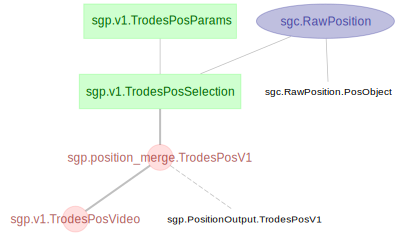

In [9]:
dj.Diagram(sgp.v1.TrodesPosSelection) -1 +2



In [26]:
entry = sgc.Session & {"nwb_file_name": "despereaux07_.nwb"}
entry

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description


In [45]:
import spyglass.lfp as lfp
import numpy as np
import pandas as pd


In [43]:
sgc.FirFilterParameters()

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest freq for stop band for low filt,filter_low_pass lowest freq for pass band of low filt,filter_high_pass highest freq for pass band for high filt,filter_high_stop highest freq for stop band of high filt,filter_comments comments about the filter,filter_band_edges numpy array of filter bands,filter_coeff numpy array of filter coefficients
LFP 0-300Hz,30000,lowpass,0.0,0.0,300.0,325.0,Alternate LFP filter for 30Khz data,=BLOB=,=BLOB=
LFP 0-400 Hz,20000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
LFP 0-400 Hz,30000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 30 KHz data,=BLOB=,=BLOB=
Ripple 150-250 Hz,1000,bandpass,140.0,150.0,250.0,260.0,ripple band filter for 1 kHz data,=BLOB=,=BLOB=
Ripple 150-250hz,1000,bandpass,125.0,150.0,250.0,275.0,Ripple filter for 1 Khz data,=BLOB=,=BLOB=
Theta 5-11 Hz,1000,bandpass,4.0,5.0,11.0,12.0,theta filter for 1 Khz data,=BLOB=,=BLOB=


In [44]:
sgc.Raw & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,raw_object_id the NWB object ID for loading this object from the file,"sampling_rate Sampling rate calculated from data, in Hz",comments,description
iris20240618_.nwb,raw data valid times,a6a87015-2d16-4c88-996c-378d131e825d,20000.0,no comments,no description


In [90]:
#filter out bad channels and any not in ca1
ca1_elecs_allgood = (
    pd.DataFrame(
        (sgc.Electrode & {"nwb_file_name": nwb_copy_file_name, "bad_channel": "False"}) 
        * (sgc.BrainRegion & {"region_name":"ca1"} ))
    .loc[:,["electrode_group_name","electrode_id"]]
)
ca1_elecs_allgood

,electrode_group_name,electrode_id
0,0,0
1,0,1
2,0,2
3,1,4
4,1,5
...,...,...
88,7,28
89,7,29
90,7,30
91,9,36


In [79]:
#select one channel per tetrode
tets = ca1_elecs_allgood["electrode_group_name"].unique()
for i in tets:
    tet_elec_ids = ca1_elecs_allgood.loc[ca1_elecs_allgood["electrode_group_name"]==str(i)].values

array([['1', 4],
       ['1', 5],
       ['1', 6],
       ['1', 7]], dtype=object)

In [48]:
electrodes_df = (
    pd.DataFrame(
        (sgc.Electrode & {"nwb_file_name": nwb_copy_file_name, "probe_electrode": 0})
        * sgc.BrainRegion
    )
    .loc[:, ["nwb_file_name", "electrode_id", "region_name"]]
    .sort_values(by="electrode_id")
)
electrodes_df

,nwb_file_name,electrode_id,region_name
0,iris20240618_.nwb,0,ca1
1,iris20240618_.nwb,4,ca1
12,iris20240618_.nwb,8,ca1
23,iris20240618_.nwb,12,ca1
26,iris20240618_.nwb,16,ca1
27,iris20240618_.nwb,20,ca1
28,iris20240618_.nwb,24,ca1
29,iris20240618_.nwb,28,ca1
30,iris20240618_.nwb,32,lost
31,iris20240618_.nwb,36,ca1
